# Description
In this notebook we fit a cultivation model to just one replicate, once with a linear calibration model for biomass and once with the asymmetric logistic one.

In [1]:
import arviz
import numpy
import pymc3
import pandas
import pathlib
from matplotlib import cm, gridspec, pyplot
import scipy.stats
from IPython.display import display

import murefi
import calibr8

import models
import plotting

DP_FIGURES = pathlib.Path("figures")
DP_PROCESSED = pathlib.Path("processed")

In [2]:
cm_biomass = models.get_biomass_model()
cm_glucose = models.get_glucose_model()
model = models.MonodModel()
dataset = murefi.load_dataset(DP_PROCESSED / "cultivation_dataset.h5")
subset = {"D06": dataset["D06"]}
theta_mapping = models.get_parameter_mapping(rids=subset.keys())
theta_mapping.as_dataframe()

,S0,X0,mu_max,K_S,Y_XS
rid,,,,,
D06,S0,X0_D06,mu_max,0.02,Y_XS


c:\users\osthege\repos\calibr8\calibr8\core.py:936: RuntimeWarning: divide by zero encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1
Parameter df (50.0) is close to its upper bound (50).
Fit of LinearCM has failed:
      fun: 48.66390806445129
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00027711,  0.00012363, -0.00312923])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 18
     njev: 29
   status: 0
  success: True
        x: array([ 1.55643528,  1.6719634 , 50.        ])


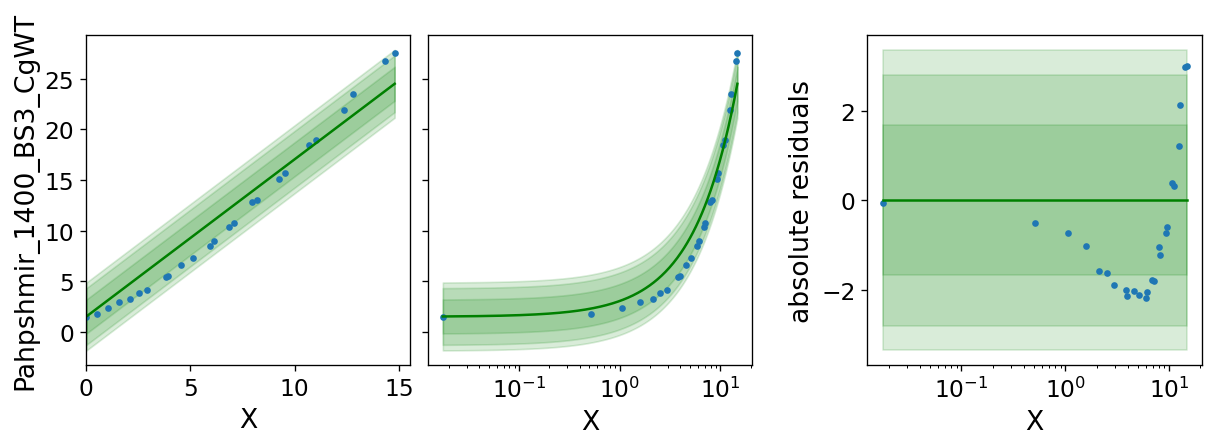

In [3]:
cm_biomass_linear = models.LinearCM(blank=cm_biomass.predict_dependent(0)[0])
#mask = numpy.logical_and(em_cdw.cal_independent > 0, em_cdw.cal_independent < 15)
mask = numpy.zeros_like(cm_biomass.cal_independent).astype(bool)
#targets = numpy.exp(numpy.linspace(numpy.log(0.01), numpy.log(15), 30))
targets = numpy.linspace(0.01, 15, 30)
for x in targets:
    i_nearest = numpy.argmin(numpy.abs(cm_biomass.cal_independent - x))
    mask[i_nearest] = True

calibr8.fit_scipy(
    cm_biomass_linear,
    independent=cm_biomass.cal_independent[mask],
    dependent=cm_biomass.cal_dependent[mask],
    theta_guess=numpy.array([2, 1, 5]).astype(float),
    theta_bounds=[
        (0, 5),
        (0.001, 5),
        (1, 50)
    ]
)
fig, axs = calibr8.plot_model(cm_biomass_linear)
axs[0].set_xlim(0)
pyplot.show()

In [4]:
df_mapping = pandas.DataFrame(columns=['rid'] + list(model.parameter_names)).set_index('rid')
for rid in subset.keys():
    df_mapping.loc[rid] = ('S0', f'X0_{rid}', 'mu_max', 0.02, 'Y_XS')
theta_mapping = murefi.ParameterMapping(
    df_mapping,
    bounds={
        'S0': (10, 30),
        'X0': (0.001, 4),
        'mu_max': (0.1, 0.6),
        'K_S': (0.0001, 0.1),
        'Y_XS': (0.3, 1)
    },
    guesses={
        'S0': 17,
        'X0': 0.2,
        'mu_max': 0.42,
        'K_S': 0.02,
        'Y_XS': 0.5
    }
)
df_mapping.head()

,S0,X0,mu_max,K_S,Y_XS
rid,,,,,
D06,S0,X0_D06,mu_max,0.02,Y_XS


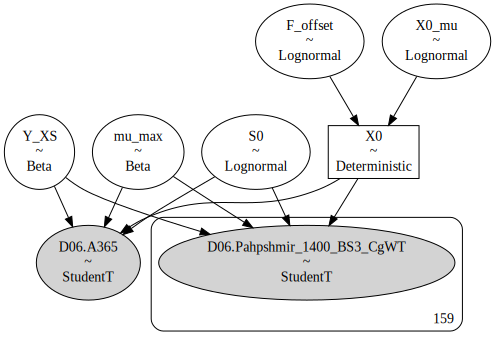

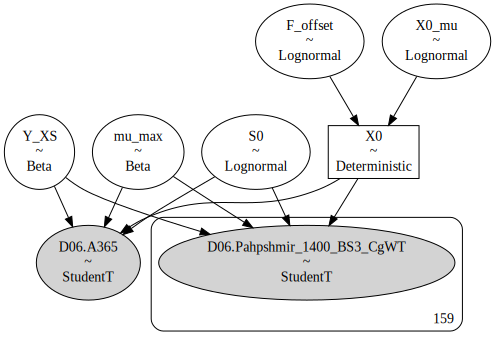

In [5]:
def build(cm_cdw):
    objective = murefi.objectives.for_dataset(
        dataset=subset,
        model=model,
        parameter_mapping=theta_mapping,
        calibration_models=[cm_glucose, cm_cdw]
    )

    with pymc3.Model(coords={
        "replicate": list(subset.keys())
    }) as pmodel:
        # Specify a hyperprior on the initial biomass group mean:
        # + centered on the planned inoculation density of 0.25 g/L in the main culture
        # + with a 10 % standard deviation to account for pipetting errors
        X0_mu = pymc3.Lognormal('X0_mu', mu=numpy.log(0.25), sd=0.10)

        # Model the relative offset of initial biomass between each well and the group mean
        # with a relative pipetting error of 20 %
        F_offset = pymc3.Lognormal('F_offset', mu=0, sd=0.20, dims=("replicate",))

        # Thereby, the initial biomass in each well is the product
        # of group mean and relative offset:
        X0 = pymc3.Deterministic('X0', X0_mu * F_offset, dims=("replicate",))

        # Combine the priors into a dictionary
        theta = {
            'S0': pymc3.Lognormal('S0', mu=numpy.log(20), sigma=0.10),
            'Y_XS': pymc3.Beta('Y_XS', mu=0.6, sd=0.05),
            'mu_max': pymc3.Beta('mu_max', mu=0.4, sd=0.1),
            # unpack the vector of initial biomasses into individual scalars
            **{
                f'X0_{rid}': X0[w]
                for w, rid in enumerate(subset.keys())
            }
        }
        L = objective(theta)
    return pmodel

def fit(pmodel):
    with pmodel:
        idata = pymc3.sample(step=pymc3.DEMetropolisZ(), return_inferencedata=True, tune=2_000, draws=3_000)
    return idata

pmodel_log = build(cm_biomass)
pmodel_lin = build(cm_biomass_linear)
display(pymc3.model_to_graphviz(pmodel_log))
display(pymc3.model_to_graphviz(pmodel_lin))

In [6]:
idata_log = fit(pmodel_log)
idata_lin = fit(pmodel_lin)

Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [mu_max, Y_XS, S0, F_offset, X0_mu]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 53 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [mu_max, Y_XS, S0, F_offset, X0_mu]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 50 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [7]:
idata_log.to_netcdf(DP_PROCESSED / "model_comparison_logistic.nc")
idata_lin.to_netcdf(DP_PROCESSED / "model_comparison_linear.nc")

WindowsPath('processed/model_comparison_linear.nc')

In [8]:
idata_log = arviz.from_netcdf(DP_PROCESSED / "model_comparison_logistic.nc")
idata_lin = arviz.from_netcdf(DP_PROCESSED / "model_comparison_linear.nc")

In [9]:
# The model with the highest "loo" value wins
pandas.DataFrame({
    "log": arviz.loo(idata_log, var_name="D06.Pahpshmir_1400_BS3_CgWT"),
    "lin": arviz.loo(idata_lin, var_name="D06.Pahpshmir_1400_BS3_CgWT"),
})

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\murefi_env\lib\site-packages\arviz\stats\stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\murefi_env\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,log,lin
loo,58.125323,-235.740579
loo_se,7.45428,0.704496
p_loo,2.120195,0.330197
n_samples,9000,9000
n_data_points,159,159
warning,False,False
loo_scale,log,log


## Make a visual comparison

In [10]:
# prediction that looks like the data (for residuals)
dpred_log = model.predict_dataset(
    template=subset,
    parameter_mapping=theta_mapping,
    parameters=plotting.extract_parameters(idata_log, theta_mapping)
)
dpred_lin = model.predict_dataset(
    template=subset,
    parameter_mapping=theta_mapping,
    parameters=plotting.extract_parameters(idata_lin, theta_mapping)
)
# prediction with high resolution
pred_log = model.predict_dataset(
    template=murefi.Dataset.make_template_like(subset, independent_keys="SX"),
    parameter_mapping=theta_mapping,
    parameters=plotting.extract_parameters(idata_log, theta_mapping)
)
pred_lin = model.predict_dataset(
    template=murefi.Dataset.make_template_like(subset, independent_keys="SX"),
    parameter_mapping=theta_mapping,
    parameters=plotting.extract_parameters(idata_lin, theta_mapping)
)

In [11]:
def get_mu_label(idata):
    µ = float(idata.posterior.mu_max.median().values)
    µ_l, µ_u = arviz.hdi(idata, var_names=["mu_max"], hdi_prob=0.9).mu_max.values
    return "$\mu_{max}=%.3f^{%.3f}_{%.3f}$" % tuple(numpy.round([µ, µ_u, µ_l], 3))
print(get_mu_label(idata_log))
print(get_mu_label(idata_lin))

$\mu_{max}=0.419^{0.423}_{0.414}$
$\mu_{max}=0.503^{0.530}_{0.480}$


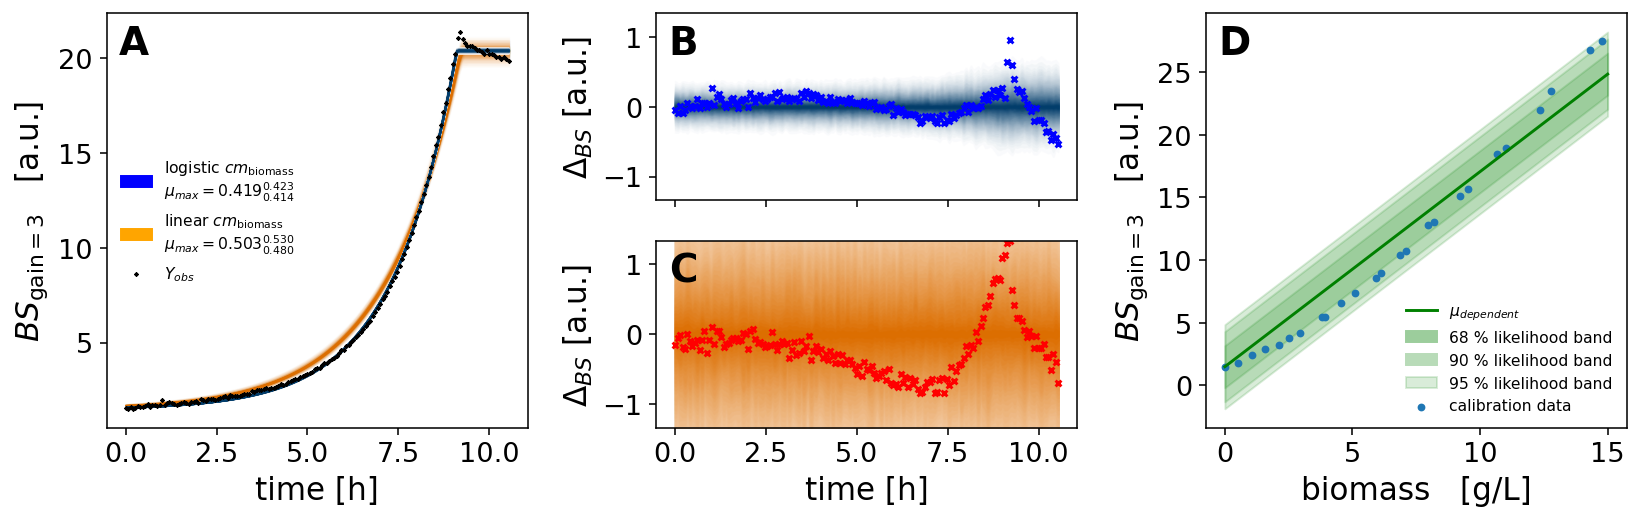

In [12]:
rid = list(subset.keys())[0]
rep = subset[rid]
ts_x = rep["Pahpshmir_1400_BS3_CgWT"]

dplog = dpred_log[rid]["Pahpshmir_1400_BS3_CgWT"]
dplin = dpred_lin[rid]["Pahpshmir_1400_BS3_CgWT"]
plog = pred_log[rid]["X"]
plin = pred_lin[rid]["X"]

clog = "blue"
cplog = plotting.FZcmaps.blue
clin = "orange"
cplin = plotting.FZcmaps.orange

fig = pyplot.figure(dpi=140, figsize=(12, 4))
gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
left = fig.add_subplot(gs[:, 0])
up = fig.add_subplot(gs[0, 1])
down = fig.add_subplot(gs[1, 1])
down.get_shared_x_axes().join(up, down)
down.get_shared_y_axes().join(up, down)
right = fig.add_subplot(gs[:, -1])

# LEFT
ax = left
# fits
loc, scale, df = cm_biomass_linear.predict_dependent(plin.y)
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=plin.t,
    #samples=scipy.stats.t.rvs(loc=loc, scale=scale, df=df),
    samples=cm_biomass_linear.predict_dependent(plin.y)[0],
    palette=cplin,
    plot_samples=False,
)
loc, scale, df = cm_biomass.predict_dependent(plog.y)
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=plog.t,
    #samples=scipy.stats.t.rvs(loc=loc, scale=scale, df=df),
    samples=cm_biomass.predict_dependent(plog.y)[0],
    palette=cplog,
    plot_samples=False,
)
# data points
ax.scatter(
    ts_x.t,
    ts_x.y,
    color="black", marker="x", s=2,
)
# legends and labels
ax.legend(
    loc='center left', fontsize=8, frameon=False,
    handles=[
        ax.fill_between(
            [], [],
            color=clog, label="logistic $cm_\mathrm{biomass}$\n" + get_mu_label(idata_log),
        ),
        ax.fill_between(
            [], [],
            color=clin, label="linear $cm_\mathrm{biomass}$\n" + get_mu_label(idata_lin),
        ),
        ax.scatter([], [], color='black', s=2, marker='x', label="$Y_{obs}$"),
    ],
)
ax.set_ylabel('$BS_\mathrm{gain=3}$   [a.u.]')
ax.set_xlabel('time [h]')

# CENTER
# residuals
ax = up
maxres = plotting.plot_residuals_pp(
    ax, cm_biomass,
    ts_x, dplog, color=clog, palette=cplog
)
ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta_{BS}$ [a.u.]')

ax = down
maxres = max(maxres, plotting.plot_residuals_pp(
    ax, cm_biomass_linear,
    ts_x, dplin, color="red", palette=cplin
))
ax.set_ylabel(r'$\Delta_{BS}$ [a.u.]')
ax.set_xlabel('time [h]')
ax.set_ylim(-maxres, maxres)

# RIGHT
ax = right
# right: linear EM
x_dense = numpy.linspace(0, 15, 100)
artists = calibr8.plot_t_band(
    ax,
    x_dense,
    *cm_biomass_linear.predict_dependent(x_dense),
    residual_type=None
)
artist_cal = ax.scatter(cm_biomass_linear.cal_independent, cm_biomass_linear.cal_dependent)
ax.set_ylabel('$BS_\mathrm{gain=3}$   [a.u.]')
ax.set_xlabel('biomass   [g/L]')
ax.legend(
    loc='lower right', fontsize=8, frameon=False,
    handles=[
        artists[0],
        artists[-1],
        artists[-3],# for whatever weird reason, the artists are in the wrong order?!
        artists[-2],
        artist_cal,
    ],
    labels=[
        '$\mu_{dependent}$',
        '68 % likelihood band',
        '90 % likelihood band',
        '95 % likelihood band',
        'calibration data',
    ]
)
left.text(0.03, 0.90, "A", transform=left.transAxes, fontsize=20, fontweight='bold')
up.text(0.03, 0.78, "B", transform=up.transAxes, fontsize=20, fontweight='bold')
down.text(0.03, 0.78, "C", transform=down.transAxes, fontsize=20, fontweight='bold')
right.text(0.03, 0.90, "D", transform=right.transAxes, fontsize=20, fontweight='bold')
fig.tight_layout()
plotting.savefig(fig, '4.2.4 PM with Linear vs. Logistic CM')
pyplot.show()

In [13]:
%load_ext watermark
%watermark

Last updated: 2021-12-15T10:34:15.636802+01:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.24.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

